## Imports

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("mandril.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import gym
import torch
import json
import numpy as np
from tqdm import trange

import maml_rl.envs
from maml_rl.baseline import LinearFeatureBaseline
from maml_rl.samplers import MultiTaskSampler
from maml_rl.utils.helpers import get_policy_for_env, get_input_size
from maml_rl.utils.reinforcement_learning import get_returns, reinforce_loss

from mazelab import MazeEnv
from mazelab.solvers import dijkstra_solver

In [2]:
def show_maze(maze, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(maze)
    if title:
        plt.title(title)
    plt.show()

In [3]:
with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(160, 50, 50)

(160, 20)

(160, 20)

In [5]:
display(logs["tasks"][0])
display(np.mean(logs["train_returns"],1))
display(np.mean(logs["valid_returns"],1))

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

array([0.6945    , 0.645     , 0.6925    , 0.68000007, 0.65950006,
       0.61200005, 0.7235    , 0.68700004, 0.68950003, 0.6585    ,
       0.66700006, 0.71050006, 0.637     , 0.73899996, 0.716     ,
       0.71450007, 0.7235    , 0.71050006, 0.69650006, 0.6635    ,
       0.72950006, 0.6125    , 0.6765    , 0.7145    , 0.7095001 ,
       0.6740001 , 0.70400006, 0.6395001 , 0.68000007, 0.733     ,
       0.65200007, 0.7085    , 0.7235001 , 0.6165001 , 0.6610001 ,
       0.73450005, 0.684     , 0.70750004, 0.71150005, 0.6475    ,
       0.683     , 0.6540001 , 0.6710001 , 0.73      , 0.6804999 ,
       0.6615001 , 0.7175001 , 0.67200005, 0.6855    , 0.6195    ,
       0.5795001 , 0.6435    , 0.6190001 , 0.689     , 0.6835    ,
       0.74950004, 0.6955    , 0.61500007, 0.643     , 0.6725    ,
       0.7530001 , 0.64000005, 0.68700004, 0.6825    , 0.70150006,
       0.68700004, 0.70500004, 0.7070001 , 0.7110001 , 0.6675    ,
       0.644     , 0.6215    , 0.6574999 , 0.6265    , 0.7055 

array([0.7095    , 0.67450005, 0.64750004, 0.70800006, 0.68050003,
       0.6495001 , 0.6345    , 0.67550004, 0.6415001 , 0.693     ,
       0.65200007, 0.725     , 0.77550006, 0.75400007, 0.6700001 ,
       0.71599996, 0.71949995, 0.63250005, 0.6715    , 0.62000006,
       0.63250005, 0.69      , 0.7295    , 0.6865    , 0.6380001 ,
       0.63900006, 0.684     , 0.695     , 0.64400005, 0.63850003,
       0.6615001 , 0.64250004, 0.64900005, 0.7505001 , 0.6575001 ,
       0.68450004, 0.6445001 , 0.6565    , 0.69      , 0.6775    ,
       0.6905001 , 0.6465    , 0.6885    , 0.67600006, 0.69100004,
       0.7010001 , 0.6445001 , 0.7495001 , 0.72450006, 0.6875    ,
       0.6245    , 0.748     , 0.63350004, 0.65550005, 0.62450004,
       0.69400007, 0.64750004, 0.66749996, 0.66200006, 0.6865    ,
       0.65550005, 0.65150005, 0.69500005, 0.7085    , 0.6280001 ,
       0.6765    , 0.64849997, 0.64449996, 0.656     , 0.6355001 ,
       0.6705001 , 0.6795    , 0.633     , 0.67950004, 0.75899

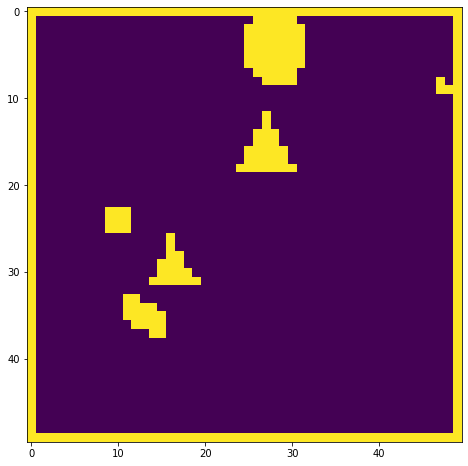

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
show_maze(x)

In [7]:
import argparse
parser = argparse.ArgumentParser(
    description='Reinforcement learning with Model-Agnostic Meta-Learning (MAML) - Test')

args = {
"config": "../maml-randomShapeMaze/config.json",
"policy": "../maml-randomShapeMaze/policy.th",

# Evaluation
"num_batches": 1,
"meta_batch_size": 1,

# Miscellaneous
"output": "maml-randomShapeMaze/results.npz",
"seed": None,
"num_workers": 1,
"device": ('cpu'),
}

height = 50
width = 50

In [8]:
try:
    gym.envs.register(
        id="RandomShapeMaze-v0",
        entry_point=MazeEnv,
        max_episode_steps=200,
        kwargs={"width": 50, "height": 50, "max_shapes": 50,
                "max_size": 8, "allow_overlap": False, "shape": None}
    )
except:
    print("environment already registered")

In [9]:
with open(args["config"], 'r') as f:
    config = json.load(f)
    if 'env-kwargs' not in config.keys(): config['env-kwargs'] = {}

env = gym.make(config['env-name'], **config['env-kwargs'])
env.close()

# configs:
fast_lr = config["fast-lr"]

In [10]:
def get_policy(policy_path):
    policy = get_policy_for_env(env,
                                hidden_sizes=config['hidden-sizes'],
                                nonlinearity=config['nonlinearity'])
    with open(policy_path, 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device(args["device"]))
        policy.load_state_dict(state_dict)
    return policy
        
policy = get_policy(args["policy"])
print(policy.layer1.bias)#.params["layer1.bias"])

Parameter containing:
tensor([-5.0741e-03, -3.4003e-03, -9.4347e-04,  5.4731e-03,  3.3771e-03,
         2.2501e-03, -2.4179e-03, -6.0790e-03,  2.9105e-03, -9.8629e-03,
         6.7990e-03,  4.5902e-03,  5.2574e-03, -3.5527e-03, -6.5621e-03,
        -1.0714e-02, -7.6542e-03, -4.0847e-03,  2.8928e-03,  3.9000e-03,
        -1.3951e-03, -7.1932e-03, -1.6175e-03, -5.2179e-03, -4.2687e-03,
         7.9949e-03, -4.2153e-03, -1.2112e-02, -3.5377e-03,  4.2693e-03,
         6.5639e-03,  1.9891e-03, -4.9038e-03,  1.1462e-02,  1.8910e-04,
        -5.5978e-03, -2.1297e-03, -2.7141e-05, -1.0168e-02, -7.9677e-03,
         5.5348e-03, -6.9713e-03,  5.6006e-03, -6.7343e-03,  2.5083e-03,
        -7.3672e-03, -1.8347e-03,  4.5130e-03, -6.8997e-03, -5.3125e-03,
         7.6319e-03, -4.0135e-05, -9.0457e-05, -1.7318e-03,  4.2900e-03,
         5.4905e-03,  7.1673e-03,  4.3237e-03,  1.0657e-02,  3.2105e-04,
        -3.5857e-03,  9.4842e-03,  8.5224e-03,  2.5220e-03],
       requires_grad=True)


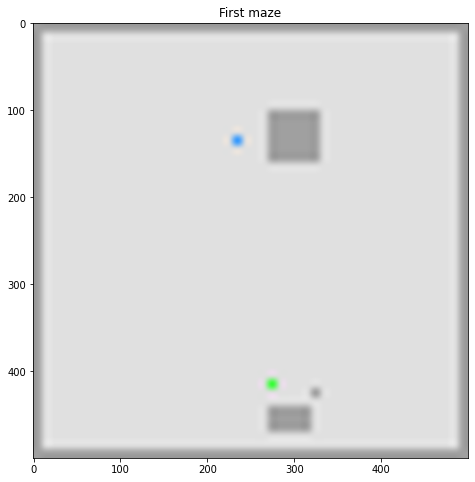

In [11]:
observations = env.reset()
img = env.render('rgb_array')
show_maze(img, "First maze")

In [12]:
def run_policy(env, observations=None, params=None):
    if observations.all == None:
        observations = env.reset()
    data = []
    path = [env.maze.objects.agent.positions[0]]
    count = 0
    reward = 0
    with torch.no_grad():
        while not (env.maze.objects.agent.positions == env.maze.objects.goal.positions) and count < 50:
            observations_tensor = torch.from_numpy(observations)
            pi = policy(observations_tensor, params=params)
            actions_tensor = pi.sample()
            actions = actions_tensor.cpu().numpy()

            new_observations, rewards, _, infos = env.step(actions)

            data.append({ "observations": observations, "actions": actions, "rewards": rewards })
            observations = new_observations
            path.append(env.maze.objects.agent.positions[0])
            count += 1
            reward += rewards
    return data, np.array(path), reward

In [13]:
def show_policy(env, params, title):
    observations = env.reset()
    maze_original = observations.reshape(height,width)
    data, path, reward = run_policy(env, observations, params)

    maze_original[path[:,0], path[:,1]] = 4
    maze_original[path[0,0], path[0,1]] = 2
    maze_original[path[-1,0], path[-1,1]] = 3
    show_maze(maze_original, title + " - reward = {0}".format(round(reward, 2)))

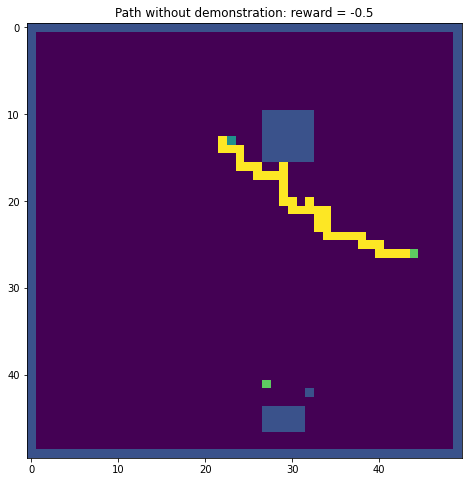

In [14]:
maze_original = observations.reshape(height,width)
data, path, reward = run_policy(env, observations)

maze_original[path[:,0], path[:,1]] = 4
maze_original[path[0,0], path[0,1]] = 2
maze_original[path[-1,0], path[-1,1]] = 3
show_maze(maze_original, "Path without demonstration: reward = {0}".format(round(reward, 2)))

## Update with example:

In [15]:
class Episodes:
    def __init__(self, batch_size, actions, rewards, observations):
        self.batch_size = batch_size
        self.actions = actions
        self.rewards = rewards
        self.observations = observations
        self.observation_shape = observations.shape[2:]
        self._lengths = None
        
    @property
    def lengths(self):
        if self._lengths is None:
            self._lengths = [len(rewards) for rewards in self.rewards]
        return self._lengths
    
    def __len__(self):
        return max(self.lengths)

In [45]:
def train_iter(policy, params=None):
    observations = env.reset()
    maze_image = env.get_image()
    impassable_array = env.unwrapped.maze.to_impassable()
    motions = env.unwrapped.motions
    start = env.unwrapped.maze.objects.agent.positions[0]
    goal = env.unwrapped.maze.objects.goal.positions[0]
    actions = dijkstra_solver(impassable_array, motions, start, goal)
    rewards = []
    observations = []
    for action in actions:
        observation, reward, _, infos = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        
    actions      = torch.tensor([actions])
    rewards      = torch.tensor([rewards])
    observations = torch.tensor([observations])
    
    episodes = Episodes(1, actions, rewards, observations)
    
    loss = reinforce_loss(policy, episodes, params=params)
    params = policy.update_params(loss,
                                  params=params,
                                  step_size=fast_lr,
                                  first_order=True)
    print(np.array(sum(rewards[0])))
    show_maze(maze_image, "dijkstra - reward = {0}".format(round(np.array(sum(rewards[0])), 2)))
    return params

In [46]:
params1 = train_iter(policy)

0.5500002


TypeError: type numpy.ndarray doesn't define __round__ method

## Check outcome after 1 iteration:

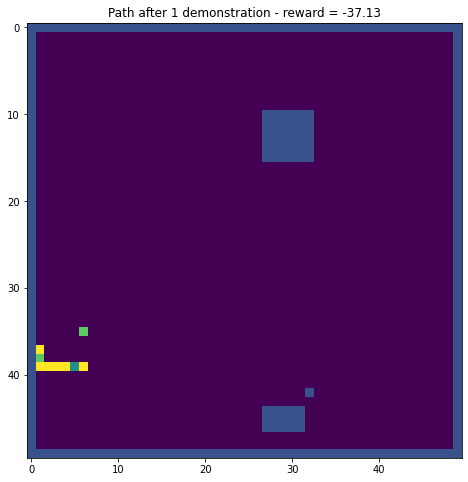

In [18]:
show_policy(env, params1, "Path after 1 demonstration")

## After 20 iterations

tensor([-0.0044, -0.0131,  0.0164,  0.0011], grad_fn=<SubBackward0>)


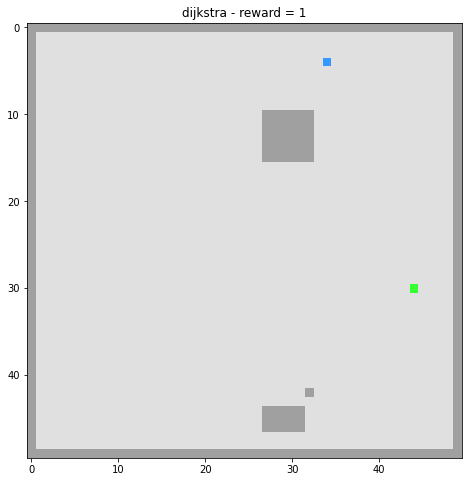

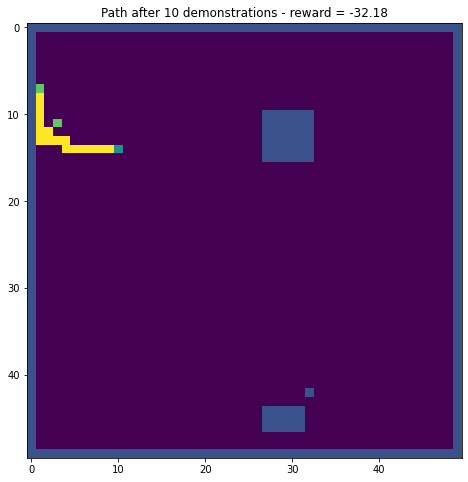

In [19]:
params2 = params1
for ii in range(1):
    print(params2["layer3.bias"])
    params2 = train_iter(policy, params2)

show_policy(env, params2, "Path after 10 demonstrations")